# ML Model Training


In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from adni_utils import df_of_csv
from modelling_evaluation_utils import *
from sklearn.decomposition import PCA

### Load The Processed Dataset


In [2]:
df = df_of_csv("FULL_DATASET", input_dir=False)
df

,DX_bl,DX,AGE,PTGENDER,PTEDUCAT,PTMARRY,PTRACCAT,APOE4,ABETA_bl,ABETA,...,ADAS13_bl,ADAS13,ADASQ4_bl,ADASQ4,mPACCdigit_bl,mPACCdigit,mPACCtrailsB_bl,mPACCtrailsB,FAQ_bl,FAQ
0,0,0,67.5,0,10,0,0,0.0,1501.0,1492.0,...,21.33,16.00,6.0,7.0,-8.42150,-6.811550,-9.449350,-6.17699,0.0,0.0
1,0,0,80.4,1,13,0,0,0.0,1289.0,1533.0,...,25.67,20.33,7.0,6.0,-10.14170,-8.117200,-10.910900,-5.27454,0.0,4.0
2,0,0,83.3,0,20,0,0,0.0,673.0,630.9,...,25.67,32.00,6.0,10.0,-6.40491,-11.731800,-7.788770,-14.19910,6.0,5.0
3,0,0,66.5,0,18,0,0,2.0,352.5,506.9,...,17.67,16.33,7.0,8.0,-5.62812,-6.811550,-6.584720,-7.13662,2.0,8.0
4,0,0,85.0,0,18,0,0,1.0,449.8,993.6,...,21.00,23.00,7.0,7.0,-7.62341,-9.865020,-8.031160,-9.98736,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0,1,87.5,1,19,2,0,0.0,664.8,524.2,...,22.67,42.00,8.0,8.0,-6.87486,-20.112100,-7.254450,-18.38850,16.0,28.0
779,1,1,61.9,1,16,0,0,0.0,802.6,1701.0,...,10.67,15.67,3.0,3.0,1.63579,-0.727494,0.147164,-3.85008,11.0,21.0
780,1,1,76.4,0,18,0,2,1.0,784.3,499.2,...,21.00,22.33,7.0,5.0,-7.26041,-6.610700,-7.234750,-7.52181,0.0,2.0
781,0,1,73.4,0,18,0,0,1.0,668.7,456.2,...,31.33,58.00,10.0,9.0,-13.01510,-25.909600,-11.765600,-25.90960,6.0,24.0


### Split The Data & Labels Into Training And Testing Sets


In [3]:
X_train, X_test, Y_train, Y_test = split_data(df, "DX")

### Check The Class Balance Between Converters And Non-Converters


In [4]:
non_converters = (df[df["DX"] == 0]).shape[0]
converters = df.shape[0] - non_converters
print(f"Count Of Data For MCI -> MCI:\t{non_converters}")
print(f"Count Of Data For MCI -> AD:\t{converters}")

Count Of Data For MCI -> MCI:	590
Count Of Data For MCI -> AD:	193


### Perform Oversampling Using Different Methods And Visualise The Results


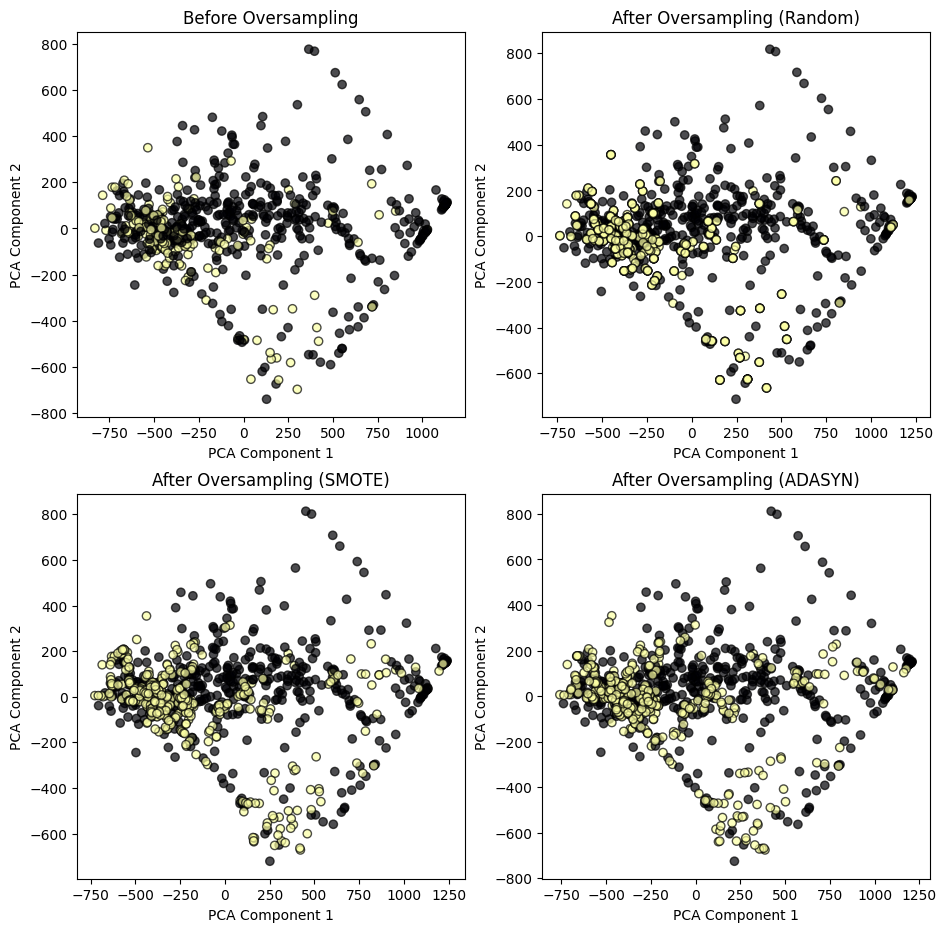

In [5]:
SEED = 42
over_samplers = [method for method in Over_samplers]

# Initialize PCA for dimensionality reduction of the dataset to a 2D space
pca = PCA(n_components=2, random_state=SEED)

# Create subplots
num_methods = round((len(over_samplers) + 1) / 2)
fig, ax = plt.subplots(num_methods, 2, figsize=(11, 11))
ax = ax.flatten()

# Function to plot a scatter plot for the given dataset
plot = lambda idx, x, y: ax[idx].scatter(
    x[:, 0], x[:, 1], c=y, cmap="inferno", edgecolors="black", alpha=0.7
)

# Plot original sample
X_train_2D = pca.fit_transform(X_train)
plot(0, X_train_2D, Y_train)
ax[0].set_title(f"Before Oversampling")
ax[0].set_xlabel("PCA Component 1")
ax[0].set_ylabel("PCA Component 2")

for idx, method in enumerate(over_samplers):
    # Apply oversampling
    X_train_resampled, Y_train_resampled = over_sample_data(
        method=method,
        X_train=X_train,
        Y_train=Y_train,
    )

    # Plot resampled data
    X_train_resampled_2D = pca.fit_transform(X_train_resampled)
    plot(idx + 1, X_train_resampled_2D, Y_train_resampled)
    ax[idx + 1].set_title(f"After Oversampling ({method.value})")
    ax[idx + 1].set_xlabel("PCA Component 1")
    ax[idx + 1].set_ylabel("PCA Component 2")

plt.show()

### Oversample The Training Dataset Using ADASYN (Adaptive Synthetic Sampling)

From the plots above, we can see that the minority class, visualised in yellow, is scattered in the original dataset, which makes it harder for such points to be classified. ADASYN focuses on generating synthetic samples for harder-to-classify regions.


In [6]:
X_train_over_sampled, Y_train_over_sampled = over_sample_data(
    method=Over_samplers.ADASYN,
    X_train=X_train,
    Y_train=Y_train,
)

In [7]:
def print_value_counts(series: pd.Series) -> None:
    """
    Prints out the number of converters and non-converters in the label series.

    Args:
        pd.Series: The labels where 0 is a non-converter and 1 is a converter

    Returns:
        None
    """
    value_counts = series.value_counts()
    count_of_non_converters = value_counts.get(0, 0)
    count_of_converters = value_counts.get(1, 0)
    print(f"Number of Non-Converters (MCI -> MCI): {count_of_non_converters}")
    print(f"Number of Converters (MCI -> AD): {count_of_converters}")


print("Before Oversampling The Dataset:")
print_value_counts(Y_train)
print()
print("After Oversampling The Dataset (Using ADASYN):")
print_value_counts(Y_train_resampled)

Before Oversampling The Dataset:
Number of Non-Converters (MCI -> MCI): 469
Number of Converters (MCI -> AD): 157

After Oversampling The Dataset (Using ADASYN):
Number of Non-Converters (MCI -> MCI): 469
Number of Converters (MCI -> AD): 455


### Perform Hyper-Parameter Tuning For Different Classification Models


In [ ]:
tuned_hyperparameters = tune_hyperparameters(
    X_train_over_sampled, X_test, Y_train_over_sampled, Y_test, random_state=SEED
)

/home/alihasan/.local/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/alihasan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alihasan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/

### Plot The Different Performance Metrics For Each Classification Model


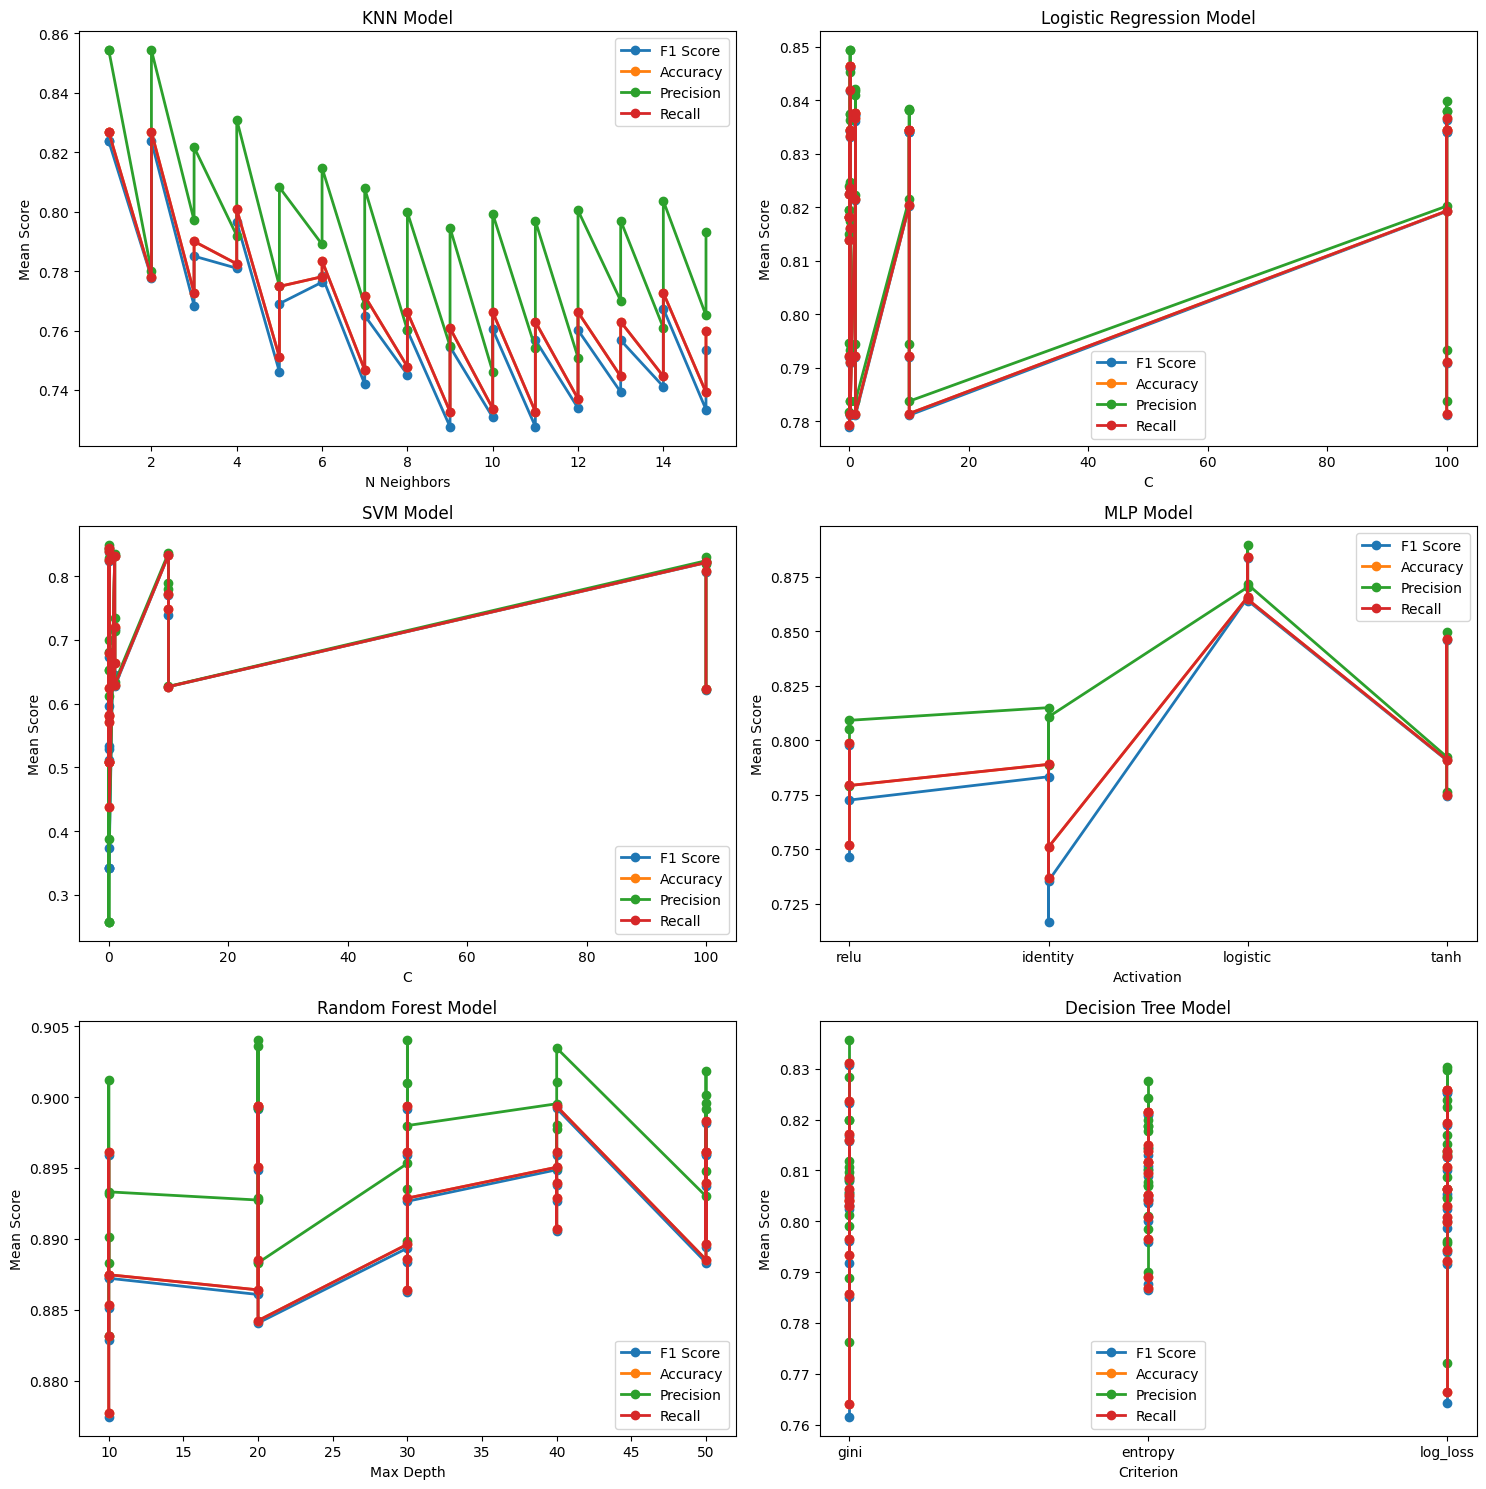

In [ ]:
fig, ax = plt.subplots(len(tuned_hyperparameters) // 2, 2, figsize=(15, 15))
ax = ax.flatten()

for i, (model_name, result) in enumerate(tuned_hyperparameters.items()):
    cv_results = result["cv_results"]
    first_param = list(result["best_params"].keys())[0]
    param_values = cv_results["param_" + first_param]
    # RandomForest and DecisionTree use None for max_depth, we need
    # to format it to be able to visualise the results in the plot
    param_values = (
        np.where(param_values.mask, -1, param_values.data)
        if isinstance(param_values, np.ma.MaskedArray)
        else np.array(pd.Series(param_values).replace([None], -1))
    )
    # Plot these specific metrics for each model
    metrics = [
        "mean_test_f1_score",
        "mean_test_recall",
        "mean_test_accuracy",
        "mean_test_precision",
    ]
    metric_names = ["F1 Score", "Recall", "Accuracy", "Precision"]
    for metric, name in zip(metrics, metric_names):
        mean_scores = cv_results[metric]
        ax[i].plot(param_values, mean_scores, label=name, marker="o", linewidth=2)
        ax[i].set_title(f"{model_name} Model")
        ax[i].set_xlabel(first_param.replace("_", " ").title())
        ax[i].set_ylabel("Mean Score")
        ax[i].legend()

plt.tight_layout()
plt.show()